# ENEM 2016

Desafio da semana: prever o valor da nota de matemática para os inscritos no ENEM 2016.

## Setup geral

In [96]:
import pandas as pd
import numpy as np
import math
import time
import gc

import matplotlib.pyplot as plt
import seaborn as sns

from orderedset import OrderedSet

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

import lightgbm as lgb

import optuna

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12, 8)
sns.set()

try:
    sklearn.set_config(display='diagram')
except:
    pass

## Carregando as bases de dados

In [13]:
df_train = pd.read_csv('train.csv', index_col=0)
df_test = pd.read_csv('test.csv')

In [14]:
df_train.head()

NU_INSCRICAO  NU_ANO  CO_MUNICIPIO_RESIDENCIA  \
1  ed50e8aaa58e7a806c337585efee9ca41f1eb1ad    2016                  4314902   
2  2c3acac4b33ec2b195d77e7c04a2d75727fad723    2016                  2304707   
3  f4545f8ccb9ff5c8aad7d32951b3f251a26e6568    2016                  2304400   
4  3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe    2016                  3304557   
5  bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268    2016                  1302603   

  NO_MUNICIPIO_RESIDENCIA  CO_UF_RESIDENCIA SG_UF_RESIDENCIA  NU_IDADE  \
1            Porto Alegre                43               RS        24   
2                  Granja                23               CE        17   
3               Fortaleza                23               CE        21   
4          Rio de Janeiro                33               RJ        25   
5                  Manaus                13               AM        28   

  TP_SEXO  TP_ESTADO_CIVIL  TP_COR_RACA  ...  Q041  Q042 Q043  Q044 Q045  \
1       M              0.0            1  ...   5.0     A    A     A    A   
2       F              0.0            3  ...   NaN     A    A     C    A   
3       F              0.0            3  ...   NaN     A    A     A    A   
4       F              0.0            0  ...   5.0     C    A     A    A   
5       M              0.0            2  ...   NaN     A    A     A    A   

   Q046  Q047  Q048  Q049  Q050  
1     A     A     A     B     D  
2     B     A     A     C     A  
3     C     A     A     B     A  
4     A     D     A     A     A  
5     A     A     A     A     A  

[5 rows x 166 columns]

In [15]:
df_test.head()

NU_INSCRICAO  CO_UF_RESIDENCIA  \
0  73ff9fcc02f0a99919906c942c2e1a1042cdcf98                41   
1  71a95f9f1b91a82c65ad94abbdf9f54e6066f968                21   
2  b38a03232f43b11c9d0788abaf060f7366053b6d                23   
3  70b682d9a3636be23f6120fa9d6b164eb3c6002d                15   
4  715494628a50142ce8cb17191cfe6d0f3cae0934                41   

  SG_UF_RESIDENCIA  NU_IDADE TP_SEXO  TP_COR_RACA  TP_NACIONALIDADE  \
0               PR        22       F            3                 1   
1               MA        26       F            3                 1   
2               CE        21       M            1                 1   
3               PA        27       F            3                 1   
4               PR        18       M            1                 1   

   TP_ST_CONCLUSAO  TP_ANO_CONCLUIU  TP_ESCOLA  ...  NU_NOTA_COMP5  \
0                1                5          1  ...           40.0   
1                1                8          1  ...          100.0   
2                2                0          2  ...           80.0   
3                1                8          1  ...            NaN   
4                2                0          2  ...            0.0   

   NU_NOTA_REDACAO  Q001  Q002  Q006  Q024  Q025  Q026  Q027  Q047  
0            420.0     B     A     C     A     A     C     C     A  
1            580.0     E     B     C     B     B     B     F     A  
2            320.0     E     E     D     B     B     A   NaN     A  
3              NaN     H     E     G     B     B     A   NaN     A  
4            320.0     D     H     H     C     B     A   NaN     A  

[5 rows x 47 columns]

## EDA

### Shapes das bases de treino e teste

In [16]:
df_train.shape

(13730, 166)

In [17]:
df_test.shape

(4576, 47)

Há muito menos colunas na base de teste do que na base de treino.

Vamos verificar quais são as colunas em comum. Não podemos assumir que todas as de teste terão na de treino também.

In [18]:
common_cols = list(OrderedSet(df_train.columns) & OrderedSet(df_test.columns))
common_cols

['NU_INSCRICAO',
 'CO_UF_RESIDENCIA',
 'SG_UF_RESIDENCIA',
 'NU_IDADE',
 'TP_SEXO',
 'TP_COR_RACA',
 'TP_NACIONALIDADE',
 'TP_ST_CONCLUSAO',
 'TP_ANO_CONCLUIU',
 'TP_ESCOLA',
 'TP_ENSINO',
 'IN_TREINEIRO',
 'TP_DEPENDENCIA_ADM_ESC',
 'IN_BAIXA_VISAO',
 'IN_CEGUEIRA',
 'IN_SURDEZ',
 'IN_DISLEXIA',
 'IN_DISCALCULIA',
 'IN_SABATISTA',
 'IN_GESTANTE',
 'IN_IDOSO',
 'TP_PRESENCA_CN',
 'TP_PRESENCA_CH',
 'TP_PRESENCA_LC',
 'CO_PROVA_CN',
 'CO_PROVA_CH',
 'CO_PROVA_LC',
 'CO_PROVA_MT',
 'NU_NOTA_CN',
 'NU_NOTA_CH',
 'NU_NOTA_LC',
 'TP_LINGUA',
 'TP_STATUS_REDACAO',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_REDACAO',
 'Q001',
 'Q002',
 'Q006',
 'Q024',
 'Q025',
 'Q026',
 'Q027',
 'Q047']

OK, são estas as colunas que temos em ambas as bases. Como teremos que prever `NU_NOTA_MT`, incluiremos ela também na nossa seleção inicial de colunas.

### Tipos e dados faltantes

In [19]:
def train_test_summary(train, test):
    """
    Traz algumas informações interessantes das bases de treino e teste
    
    :param train: pd.DataFrame de treino
    :param test: pd.DataFrame de teste
    :returns: pd.DataFrame contendo as informações comparativas
    """
    return pd.DataFrame({
        'dtype': train.dtypes,
        'train nulls': train.isna().sum(),
        'train nulls (%)': train.isna().mean(),
        'train nunique': train.nunique(),
        'test nulls': test.isna().sum(),
        'test nulls (%)': test.isna().mean(),
        'test nunique': test.nunique()
    })

train_test_summary(df_train[common_cols + ['NU_NOTA_MT']], df_test[common_cols])

dtype  train nulls  train nulls (%)  train nunique  \
CO_PROVA_CH              object            0         0.000000             10   
CO_PROVA_CN              object            0         0.000000             10   
CO_PROVA_LC              object            0         0.000000              9   
CO_PROVA_MT              object            0         0.000000              9   
CO_UF_RESIDENCIA          int64            0         0.000000             27   
IN_BAIXA_VISAO            int64            0         0.000000              2   
IN_CEGUEIRA               int64            0         0.000000              1   
IN_DISCALCULIA            int64            0         0.000000              2   
IN_DISLEXIA               int64            0         0.000000              2   
IN_GESTANTE               int64            0         0.000000              2   
IN_IDOSO                  int64            0         0.000000              2   
IN_SABATISTA              int64            0         0.000000              2   
IN_SURDEZ                 int64            0         0.000000              2   
IN_TREINEIRO              int64            0         0.000000              2   
NU_IDADE                  int64            0         0.000000             55   
NU_INSCRICAO             object            0         0.000000          13730   
NU_NOTA_CH              float64         3389         0.246832           2978   
NU_NOTA_CN              float64         3389         0.246832           2692   
NU_NOTA_COMP1           float64         3597         0.261981             15   
NU_NOTA_COMP2           float64         3597         0.261981             13   
NU_NOTA_COMP3           float64         3597         0.261981             12   
NU_NOTA_COMP4           float64         3597         0.261981             14   
NU_NOTA_COMP5           float64         3597         0.261981             14   
NU_NOTA_LC              float64         3597         0.261981           2774   
NU_NOTA_MT              float64         3597         0.261981           3406   
NU_NOTA_REDACAO         float64         3597         0.261981             53   
Q001                     object            0         0.000000              8   
Q002                     object            0         0.000000              8   
Q006                     object            0         0.000000             17   
Q024                     object            0         0.000000              5   
Q025                     object            0         0.000000              2   
Q026                     object            0         0.000000              3   
Q027                     object         7373         0.536999             13   
Q047                     object            0         0.000000              5   
SG_UF_RESIDENCIA         object            0         0.000000             27   
TP_ANO_CONCLUIU           int64            0         0.000000             11   
TP_COR_RACA               int64            0         0.000000              6   
TP_DEPENDENCIA_ADM_ESC  float64         9448         0.688128              4   
TP_ENSINO               float64         9448         0.688128              3   
TP_ESCOLA                 int64            0         0.000000              4   
TP_LINGUA                 int64            0         0.000000              2   
TP_NACIONALIDADE          int64            0         0.000000              5   
TP_PRESENCA_CH            int64            0         0.000000              3   
TP_PRESENCA_CN            int64            0         0.000000              3   
TP_PRESENCA_LC            int64            0         0.000000              3   
TP_SEXO                  object            0         0.000000              2   
TP_STATUS_REDACAO       float64         3597         0.261981              9   
TP_ST_CONCLUSAO           int64            0         0.000000              4   

                        test nulls  test nulls (%)  test nunique  
CO_PROVA_CH                    0.0    

Podemos observar que, pelos percentuais de dados faltantes, as bases estão divididas proporcionalmente, o que é bom. Note que há colunas categóricas que há muitos dados faltantes. Vamos retirar essas de imediato.

Vamos tirar também `IN_CEGUEIRA`, pois só há um valor distinto em ambas as bases.

Antes de removermos algumas colunas, vamos criar uma coluna `IN_PCD` que indicará todos aqueles que possuem algum tipo de deficiência. Depois podemos remover todas as colunas relacionadas a isso.

In [20]:
df_train['IN_PCD'] = np.int64(df_train.IN_BAIXA_VISAO | 
                              df_train.IN_CEGUEIRA | 
                              df_train.IN_SURDEZ |
                              df_train.IN_DEFICIENCIA_AUDITIVA |
                              df_train.IN_SURDO_CEGUEIRA |
                              df_train.IN_DEFICIENCIA_FISICA |
                              df_train.IN_DEFICIENCIA_MENTAL |
                              df_train.IN_DEFICIT_ATENCAO |
                              df_train.IN_DISLEXIA |
                              df_train.IN_DISCALCULIA |
                              df_train.IN_AUTISMO |
                              df_train.IN_VISAO_MONOCULAR | 
                              df_train.IN_OUTRA_DEF)

df_test['IN_PCD'] = np.int64(df_test.IN_BAIXA_VISAO | 
                             df_test.IN_CEGUEIRA | 
                             df_test.IN_SURDEZ |
                             df_test.IN_DISLEXIA |
                             df_test.IN_DISCALCULIA)

common_cols.append('IN_PCD')

Agora sim podemos equalizar as colunas.

In [21]:
target_col = 'NU_NOTA_MT'

df_train = df_train[common_cols + [target_col]]
# garantindo a mesma ordem das colunas
df_test = df_test[common_cols]

In [22]:
# juntando os 2 facilita a criação de novas features
data = pd.concat([df_train, df_test], keys=['train', 'test'])
data.head()

CO_PROVA_CH  \
train 1  9cd70f1b922e02bd33453b3f607f5a644fb9b1b8   
      2  909237ab0d84688e10c0470e2997348aff585273   
      3  2d22ac1d42e6187f09ee6c578df187a760123ccf   
      4  2d22ac1d42e6187f09ee6c578df187a760123ccf   
      5  2d22ac1d42e6187f09ee6c578df187a760123ccf   

                                      CO_PROVA_CN  \
train 1  16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2   
      2  b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7   
      3  2d22ac1d42e6187f09ee6c578df187a760123ccf   
      4  2d22ac1d42e6187f09ee6c578df187a760123ccf   
      5  2d22ac1d42e6187f09ee6c578df187a760123ccf   

                                      CO_PROVA_LC  \
train 1  01af53cd161a420fff1767129c10de560cc264dd   
      2  01af53cd161a420fff1767129c10de560cc264dd   
      3  2d22ac1d42e6187f09ee6c578df187a760123ccf   
      4  2d22ac1d42e6187f09ee6c578df187a760123ccf   
      5  2d22ac1d42e6187f09ee6c578df187a760123ccf   

                                      CO_PROVA_MT  CO_UF_RESIDENCIA  \
train 1  97caab1e1533dba217deb7ef41490f52e459ab01                43   
      2  97caab1e1533dba217deb7ef41490f52e459ab01                23   
      3  2d22ac1d42e6187f09ee6c578df187a760123ccf                23   
      4  2d22ac1d42e6187f09ee6c578df187a760123ccf                33   
      5  2d22ac1d42e6187f09ee6c578df187a760123ccf                13   

         IN_BAIXA_VISAO  IN_CEGUEIRA  IN_DISCALCULIA  IN_DISLEXIA  \
train 1               0            0               0            0   
      2               0            0               0            0   
      3               0            0               0            0   
      4               0            0               0            0   
      5               0            0               0            0   

         IN_GESTANTE  ...  TP_ENSINO  TP_ESCOLA  TP_LINGUA  TP_NACIONALIDADE  \
train 1            0  ...        NaN          1          1                 1   
      2            0  ...        1.0          2          1                 1   
      3            0  ...        NaN          1          1                 1   
      4            0  ...        NaN          1          0                 1   
      5            0  ...        NaN          1          1                 1   

         TP_PRESENCA_CH  TP_PRESENCA_CN TP_PRESENCA_LC  TP_SEXO  \
train 1               1               1              1        M   
      2               1               1              1        F   
      3               0               0              0        F   
      4               0               0              0        F   
      5               0               0              0        M   

         TP_STATUS_REDACAO  TP_ST_CONCLUSAO  
train 1                1.0                1  
      2                1.0                2  
      3                NaN                3  
      4                NaN                1  
      5                NaN                1  

[5 rows x 49 columns]

In [25]:
cols_to_drop = [
    'Q027',                   # muitos dados nulos
    'TP_DEPENDENCIA_ADM_ESC', # muitos dados nulos
    'TP_ENSINO',              # muitos dados nulos
    'SG_UF_RESIDENCIA',       # já existe uma coluna codificada dela
    'IN_BAIXA_VISAO',         # já condensamos na IN_PCD
    'IN_CEGUEIRA',            # já condensamos na IN_PCD
    'IN_SURDEZ',              # já condensamos na IN_PCD
    'IN_DISLEXIA',            # já condensamos na IN_PCD
    'IN_DISCALCULIA'          # já condensamos na IN_PCD
]

data.drop(columns=cols_to_drop, inplace=True)

### Tratando dados nulos

In [26]:
def nullity_heatmap(dataframe):
    """
    Plota heatmap de correlação dos dados nulos.
    
    :param dataframe: pd.DataFrame com os dados para serem correlacionados.
    """
    corr = dataframe.isna().corr()
    cols = corr.columns[corr.count()>0]
    corr = corr.loc[cols, cols]
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, cmap='RdBu', annot=True, vmin=-1, vmax=1, fmt='.2f')

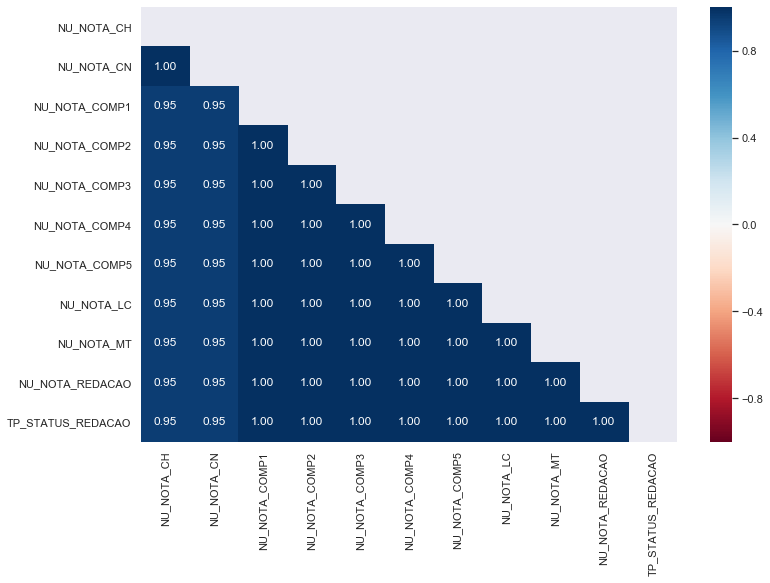

In [28]:
nullity_heatmap(data.xs('train'))

Podemos observar que quando os dados da redação ou de LC estão nulos, a nota de MT também está. O que indica fortemente de que a pessoa não foi para fazer a prova do 2º dia. 

Também podemos perceber que boa parte daqueles que não fizeram a prova no 1º dia, também não compareceram para fazer a prova no 2º dia (chutou o balde!)

#### Preenchendo dados nulos

Como os dados nulos estão relacionados com aqueles que não fizeram a prova, podemos assumir que a nota é zero.

In [29]:
cols_to_fix = [
    'NU_NOTA_CH', 
    'NU_NOTA_CN',
    'NU_NOTA_LC',
    'NU_NOTA_MT',
    'NU_NOTA_COMP1', 
    'NU_NOTA_COMP2', 
    'NU_NOTA_COMP3', 
    'NU_NOTA_COMP4', 
    'NU_NOTA_COMP5',
    'NU_NOTA_REDACAO'
]

for col in cols_to_fix:
    data[col] = data[col].fillna(0.)

Vamos fazer o mesmo com `TP_STATUS_REDACAO`. Neste caso, resolvi atribuir um status que não existe. Algo como: "não foi".

In [30]:
cols_to_fix = [
    'TP_STATUS_REDACAO'
]

for col in cols_to_fix:
    data[col] = data[col].fillna(0.).astype(int)

### Codificando features do tipo `object`

Antes de realizarmos algum tipo de visualização, vou converter algumas colunas com `OrdinalEncoder`.

In [31]:
cols_to_encode = [
    'CO_PROVA_CH',
    'CO_PROVA_CN',
    'CO_PROVA_LC',
    'CO_PROVA_MT',
    'Q001',
    'Q002',
    'Q006',
    'Q024',
    'Q025',
    'Q026',
    'Q047',
    'TP_SEXO'
]

for col in cols_to_encode:
    print(f'Codificando feature {col}')
    
    encoder = OrdinalEncoder()
    encoder.fit(data[col].to_frame())
    
    data[col] = encoder.transform(data[col].to_frame())

Codificando feature CO_PROVA_CH
Codificando feature CO_PROVA_CN
Codificando feature CO_PROVA_LC
Codificando feature CO_PROVA_MT
Codificando feature Q001
Codificando feature Q002
Codificando feature Q006
Codificando feature Q024
Codificando feature Q025
Codificando feature Q026
Codificando feature Q047
Codificando feature TP_SEXO


## Feature engineering

Vamos agora criar features que possam ser relevantes ao nosso modelo.

### `NU_IDADE`

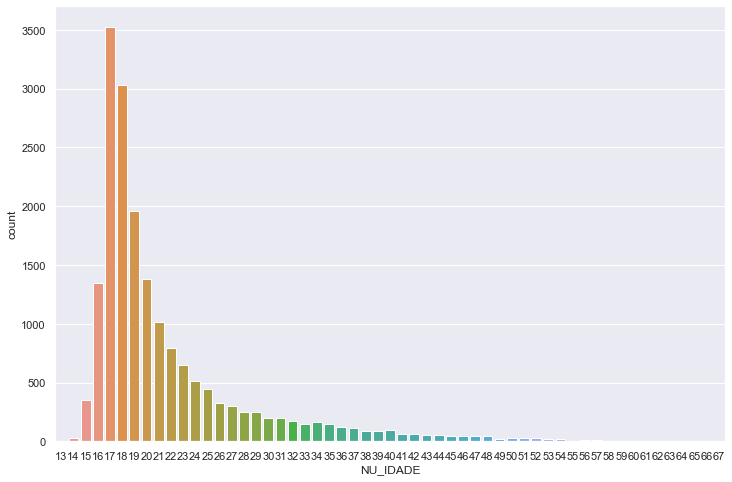

In [32]:
sns.countplot(x='NU_IDADE', data=data);

Podemos ver que há algumas distribuições e concentrações em algumas idades. Vou criar uma coluna categórica para isso.

In [43]:
data['TP_IDADE_AGRUPADA'] = pd.cut(data['NU_IDADE'], bins=[0, 17, 19, 21, 26, 31, 41, 100], labels=range(7)).ravel()
# as colunas de idade e indicando se é idoso não fazem mais sentido
data.drop(columns=['NU_IDADE', 'IN_IDOSO'], inplace=True)

### `TP_NACIONALIDADE`

Neste caso, vou criar uma feature para identificar se a pessoa é estrangeira ou não.

In [45]:
data['IN_ESTRANGEIRO'] = np.int64(~data['TP_NACIONALIDADE'].isin([0, 1, 2, 4]))
data.drop(columns=['TP_NACIONALIDADE'], inplace=True)

### Codificando grupos de features categóricas

Codificar features categóricas é uma arte. Existem várias estratégias, como a que foi apresentado em curso, mas uma que eu gosto bastante é a *smooth encode*, que é similar a do `CatBoost`, mas me permite agrupar mais de uma coluna para calcular a média do target naquele agrupamento. Para evitar um overfitting, podemos aplicar um ruído randômico.

In [46]:
def add_noise(series, noise_level):
    """
    Adiciona ruído randômico à série
    
    :param series: pd.Series de entrada
    :param noise_level: nível de ruído
    :returns: a mesma série com o ruído aplicado
    """
    return series * (1 + noise_level * np.random.randn(len(series)))

def smooth_encode(train_data, test_data, cols, target_column_name, encoded_column_name, 
                  min_samples_leaf=1, smoothing=1, noise_level=0):
    """
    Codifica variável categórica com Smooth Encoder. Num futuro podemos englobar isso em um modelo no padrão scikit-learn.
    
    :param train_data: pd.DataFrame com os dados de treino (para o fit interno)
    :param test_data: pd.DataFrame com os dados de teste (para o transform interno)
    :param cols: colunas que serão codificadas de forma agrupada
    :param target_column_name: nome da coluna alvo
    :param encoded_column_name: nome da coluna que terá os dados codificados
    :param min_samples_leaf: granularidade do codificador
    :param smoothing: suavidade do codificador
    :param noise_level: nível de ruído (ajuda a evitar overfitting)
    :returns: tupla com os 2 dataframes (treino e teste) com a coluna adicionada
    """
    # calcula médias agrupadas
    averages = train_data.groupby(by=cols)[target_column_name].agg(['mean', 'count'])
    # calcula suavidade com os parâmetros indicados
    smoothing = 1 / (1 + np.exp(-(averages['count'] - min_samples_leaf) / smoothing))
    # caso não seja possível cruzar o agrupamento nas bases, usa a média do target como valor
    prior = train_data[target_column_name].mean()
    
    # nosso novo valor será uma interpolação entre a média do target com o que calculamos
    averages[target_column_name] = prior * (1 - smoothing) + averages['mean'] * smoothing
    
    averages.drop(['mean', 'count'], axis=1, inplace=True)
    
    averages.columns = [encoded_column_name]
    averages.reset_index(inplace=True)

    # adiciona coluna à base de treino
    tr_result = pd.merge(train_data, averages, on=cols, how='left')
    tr_result[encoded_column_name].fillna(prior, inplace=True)
    tr_result[encoded_column_name] = add_noise(tr_result[encoded_column_name], noise_level)
    # adiciona coluna à base de teste
    ts_result = pd.merge(test_data, averages, on=cols, how='left')
    ts_result[encoded_column_name].fillna(prior, inplace=True)
    ts_result[encoded_column_name] = add_noise(ts_result[encoded_column_name], noise_level)
    
    return tr_result, ts_result

In [47]:
groups = [
    (['CO_UF_RESIDENCIA'], 'ENC_UF_RESIDENCIA'),
    (['CO_UF_RESIDENCIA', 'TP_COR_RACA'], 'ENC_UF_RESIDENCIA_COR_RACA'),
    (['CO_UF_RESIDENCIA', 'TP_IDADE_AGRUPADA'], 'ENC_UF_RESIDENCIA_IDADE_AGRUPADA'),
    (['CO_UF_RESIDENCIA', 'TP_SEXO'], 'ENC_UF_RESIDENCIA_SEXO'),
    (['CO_UF_RESIDENCIA', 'Q006'], 'ENC_UF_RESIDENCIA_Q006'),
    (['TP_COR_RACA'], 'ENC_COR_RACA'),
    (['TP_COR_RACA', 'TP_IDADE_AGRUPADA'], 'ENC_COR_RACA_IDADE_AGRUPADA'),
    (['TP_COR_RACA', 'TP_SEXO'], 'ENC_COR_RACA_SEXO'),
    (['TP_COR_RACA', 'Q006'], 'ENC_TP_COR_RACA_Q006'),
    (['TP_IDADE_AGRUPADA'], 'ENC_IDADE_AGRUPADA'),
    (['TP_IDADE_AGRUPADA', 'TP_SEXO'], 'ENC_IDADE_AGRUPADA_SEXO'),
    (['CO_UF_RESIDENCIA', 'TP_COR_RACA', 'TP_IDADE_AGRUPADA'], 'ENC_UF_RESIDENCIA_COR_RACA_IDADE_AGRUPADA'),
    (['CO_UF_RESIDENCIA', 'TP_COR_RACA', 'TP_IDADE_AGRUPADA', 'TP_SEXO'], 'ENC_UF_RESIDENCIA_COR_RACA_IDADE_AGRUPADA_SEXO'),
    (['IN_TREINEIRO'], 'ENC_TREINEIRO'),
    (['IN_TREINEIRO', 'TP_SEXO'], 'ENC_TREINEIRO_SEXO'),
]

np.random.seed(0)

min_samples_leaf = 10
smoothing = 2
noise_level = 0.01

train, test = data.xs('train'), data.xs('test')

for g in groups:
    ts = time.time()
    
    cols, column_name = g
    
    train, test = smooth_encode(train_data=train, 
                                test_data=test, 
                                cols=cols,
                                target_column_name=target_col, 
                                encoded_column_name=column_name,
                                min_samples_leaf=min_samples_leaf,
                                smoothing=smoothing,
                                noise_level=noise_level)
    
    print('{} criada! ({:.4f}s)'.format(column_name, time.time() - ts))
    
data = pd.concat([train, test], keys=['train', 'test'])

ENC_UF_RESIDENCIA criada! (0.1500s)
ENC_UF_RESIDENCIA_COR_RACA criada! (0.0940s)
ENC_UF_RESIDENCIA_IDADE_AGRUPADA criada! (0.1370s)
ENC_UF_RESIDENCIA_SEXO criada! (0.1660s)
ENC_UF_RESIDENCIA_Q006 criada! (0.1300s)
ENC_COR_RACA criada! (0.0970s)
ENC_COR_RACA_IDADE_AGRUPADA criada! (0.1410s)
ENC_COR_RACA_SEXO criada! (0.1360s)
ENC_TP_COR_RACA_Q006 criada! (0.1470s)
ENC_IDADE_AGRUPADA criada! (0.1150s)
ENC_IDADE_AGRUPADA_SEXO criada! (0.1740s)
ENC_UF_RESIDENCIA_COR_RACA_IDADE_AGRUPADA criada! (0.1490s)
ENC_UF_RESIDENCIA_COR_RACA_IDADE_AGRUPADA_SEXO criada! (0.1900s)
ENC_TREINEIRO criada! (0.2080s)
ENC_TREINEIRO_SEXO criada! (0.2400s)


## Limpeza dos dados

Vamos agora confrontar os valores que estão em treino com os que estão em teste para sabermos se podemos retirar registros desnecessários.

In [48]:
categorical_features = [
    'CO_PROVA_CH',
    'CO_PROVA_CN',
    'CO_PROVA_LC',
    'CO_PROVA_MT',
    'CO_UF_RESIDENCIA',
    'IN_GESTANTE',
    'IN_PCD',
    'IN_SABATISTA',
    'IN_TREINEIRO',
    'Q001',
    'Q002',
    'Q006',
    'Q024',
    'Q025',
    'Q026',
    'Q047',
    'TP_ANO_CONCLUIU',
    'TP_COR_RACA',
    'TP_ESCOLA',
    'TP_LINGUA',
    'TP_PRESENCA_CH',
    'TP_PRESENCA_CN',
    'TP_PRESENCA_LC',
    'TP_SEXO',
    'TP_STATUS_REDACAO',
    'TP_ST_CONCLUSAO',
    'TP_IDADE_AGRUPADA', 
    'IN_ESTRANGEIRO'
]

In [49]:
train, test = data.xs('train'), data.xs('test')

for col in categorical_features:
    print(col)
    train_set = set(train[col].unique())
    test_set = set(test[col].unique())
    
    labels_not_found = list(train_set - test_set)
    ratio = float(len(train[train[col].isin(labels_not_found)])) / float(len(train[col]))
    print(f'  Não existem na base de teste: {labels_not_found} ({ratio})')
    
    labels_not_found = list(test_set - train_set)
    ratio = float(len(test[test[col].isin(labels_not_found)])) / float(len(test[col]))
    print(f'  Não existem na base de treino: {labels_not_found} ({ratio})')
    
    print('')

CO_PROVA_CH
  Não existem na base de teste: [7.0] (7.283321194464675e-05)
  Não existem na base de treino: [] (0.0)

CO_PROVA_CN
  Não existem na base de teste: [6.0] (7.283321194464675e-05)
  Não existem na base de treino: [] (0.0)

CO_PROVA_LC
  Não existem na base de teste: [] (0.0)
  Não existem na base de treino: [] (0.0)

CO_PROVA_MT
  Não existem na base de teste: [] (0.0)
  Não existem na base de treino: [] (0.0)

CO_UF_RESIDENCIA
  Não existem na base de teste: [] (0.0)
  Não existem na base de treino: [] (0.0)

IN_GESTANTE
  Não existem na base de teste: [] (0.0)
  Não existem na base de treino: [] (0.0)

IN_PCD
  Não existem na base de teste: [] (0.0)
  Não existem na base de treino: [] (0.0)

IN_SABATISTA
  Não existem na base de teste: [] (0.0)
  Não existem na base de treino: [] (0.0)

IN_TREINEIRO
  Não existem na base de teste: [] (0.0)
  Não existem na base de treino: [] (0.0)

Q001
  Não existem na base de teste: [] (0.0)
  Não existem na base de treino: [] (0.0)

Q00

Beleza! Agora é só removermos os dados da base de treino.

In [50]:
data = data[~data['CO_PROVA_CH'].isin([7])]
data = data[~data['CO_PROVA_CN'].isin([6])]
data = data[~data['TP_ESCOLA'].isin([4])]
data = data[~data['TP_PRESENCA_CH'].isin([2])]
data = data[~data['TP_PRESENCA_CN'].isin([2])]

In [51]:
data.dtypes

CO_PROVA_CH                                       float64
CO_PROVA_CN                                       float64
CO_PROVA_LC                                       float64
CO_PROVA_MT                                       float64
CO_UF_RESIDENCIA                                    int64
IN_GESTANTE                                         int64
IN_PCD                                              int64
IN_SABATISTA                                        int64
IN_TREINEIRO                                        int64
NU_INSCRICAO                                       object
NU_NOTA_CH                                        float64
NU_NOTA_CN                                        float64
NU_NOTA_COMP1                                     float64
NU_NOTA_COMP2                                     float64
NU_NOTA_COMP3                                     float64
NU_NOTA_COMP4                                     float64
NU_NOTA_COMP5                                     float64
NU_NOTA_LC    

In [52]:
data.head()

CO_PROVA_CH  CO_PROVA_CN  CO_PROVA_LC  CO_PROVA_MT  CO_UF_RESIDENCIA  \
train 0          5.0          1.0          1.0          8.0                43   
      1          3.0          7.0          1.0          8.0                23   
      2          1.0          3.0          2.0          2.0                23   
      3          1.0          3.0          2.0          2.0                33   
      4          1.0          3.0          2.0          2.0                13   

         IN_GESTANTE  IN_PCD  IN_SABATISTA  IN_TREINEIRO  \
train 0            0       0             0             0   
      1            0       0             0             0   
      2            0       0             0             0   
      3            0       0             0             0   
      4            0       0             0             0   

                                     NU_INSCRICAO  ...  ENC_COR_RACA  \
train 0  ed50e8aaa58e7a806c337585efee9ca41f1eb1ad  ...    382.822152   
      1  2c3acac4b33ec2b195d77e7c04a2d75727fad723  ...    345.708606   
      2  f4545f8ccb9ff5c8aad7d32951b3f251a26e6568  ...    347.199482   
      3  3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe  ...    343.363100   
      4  bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268  ...    343.071970   

         ENC_COR_RACA_IDADE_AGRUPADA  ENC_COR_RACA_SEXO  ENC_TP_COR_RACA_Q006  \
train 0                   289.411190         409.737843            331.366003   
      1                   401.689794         331.055244            342.179743   
      2                   330.250242         336.176075            326.328214   
      3                   340.224320         338.068439            363.597554   
      4                   212.647931         352.897592            327.578903   

         ENC_IDADE_AGRUPADA  ENC_IDADE_AGRUPADA_SEXO  \
train 0          282.387084               301.143420   
      1          435.174604               421.099783   
      2          336.880899               319.470064   
      3          286.286413               270.128455   
      4          247.245690               272.179326   

         ENC_UF_RESIDENCIA_COR_RACA_IDADE_AGRUPADA  \
train 0                                 246.082626   
      1                                 399.730647   
      2                                 288.797789   
      3                                 343.736522   
      4                                 351.024787   

         ENC_UF_RESIDENCIA_COR_RACA_IDADE_AGRUPADA_SEXO  ENC_TREINEIRO  \
train 0                                      258.466230     341.751805   
      1                                      405.543946     348.678538   
      2                                      303.592668     346.535958   
      3                                      347.148623     352.290754   
      4                                      352.821801     347.692978   

         ENC_TREINEIRO_SEXO  
train 0          368.854082  
      1          333.765981  
      2          338.916968  
      3          330.047230  
      4          367.583443  

[5 rows x 54 columns]

### Separação dos registros de quem não fez a prova de MT

A ideia agora é montarmos prepararmos nossa base para criarmos um modelo para quem esteve presente para fazer a prova de matemática. Para quem não esteve presente, vamos atribuir a nota zero.

In [53]:
data['ELIMINADO'] = data['TP_PRESENCA_LC']!=1
data.drop(columns=['TP_PRESENCA_LC'], inplace=True)
categorical_features.remove('TP_PRESENCA_LC')

## Visualizações

In [70]:
train_data, test_data = data.xs('train'), data.xs('test')
train_data = train_data[train_data['ELIMINADO']==0]
test_data = test_data[test_data['ELIMINADO']==0]

### Correlação das features com target

In [71]:
numeric_features = list(data.columns[~data.columns.isin(categorical_features + ['NU_INSCRICAO', 'ELIMINADO', target_col])])
numeric_features

['NU_NOTA_CH',
 'NU_NOTA_CN',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP2',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_COMP5',
 'NU_NOTA_LC',
 'NU_NOTA_REDACAO',
 'ENC_UF_RESIDENCIA',
 'ENC_UF_RESIDENCIA_COR_RACA',
 'ENC_UF_RESIDENCIA_IDADE_AGRUPADA',
 'ENC_UF_RESIDENCIA_SEXO',
 'ENC_UF_RESIDENCIA_Q006',
 'ENC_COR_RACA',
 'ENC_COR_RACA_IDADE_AGRUPADA',
 'ENC_COR_RACA_SEXO',
 'ENC_TP_COR_RACA_Q006',
 'ENC_IDADE_AGRUPADA',
 'ENC_IDADE_AGRUPADA_SEXO',
 'ENC_UF_RESIDENCIA_COR_RACA_IDADE_AGRUPADA',
 'ENC_UF_RESIDENCIA_COR_RACA_IDADE_AGRUPADA_SEXO',
 'ENC_TREINEIRO',
 'ENC_TREINEIRO_SEXO']

In [72]:
def corr_to_target(dataframe, target, title=None):
    """
    Apresenta heatmap apenas do nosso target com as demais features
    
    :param dataframe: dataframe contendo features e target
    :param target: nome da coluna do target
    :param title: título do nosso gráfico
    """
    plt.figure(figsize=(4, 10))
    sns.heatmap(dataframe.corr()[[target]].sort_values(target, ascending=False)[1:], 
                annot=True, 
                fmt='.2f',
                cmap='coolwarm')
    
    if title:
        plt.title(f'\n{title}\n', fontsize=18)
    
    plt.xlabel('')
    plt.ylabel('')
    plt.show()

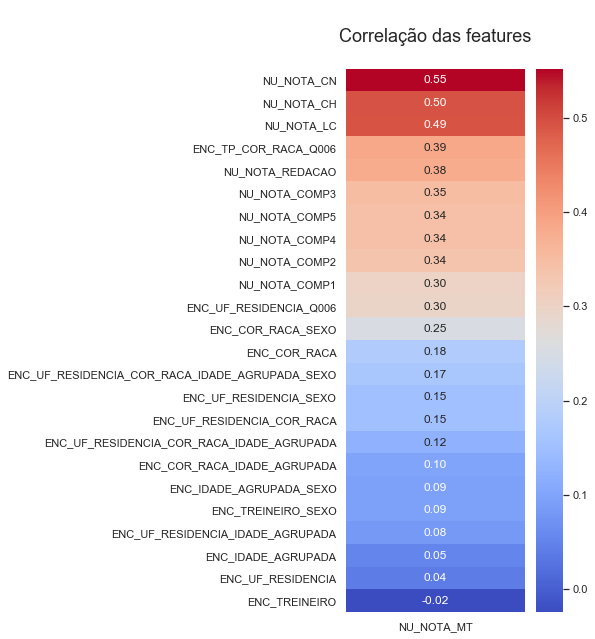

In [73]:
corr_to_target(train_data[numeric_features + [target_col]], target_col, title='Correlação das features')

Beleza! Criamos diversas features e muitas delas ganharam destaque para montarmos nosso modelo.

É interessante ver as features que estão relacionadas à `Q006` que é sobre renda familiar. Quanto mais alta a renda, maior a nota de matemática.

### Gráficos de distribuição das features em ambas as bases

In [74]:
def gen_distplots(train, test, features, cols=1, title=''):
    """
    Apresenta gráficos de distribuição de valores de treino e teste sobrepostos para cada feature indicada
    
    :param train: dataframe de treino
    :param test: dataframe de teste
    :param features: features que queremos apresentar
    :param cols: número máximo de colunas da grade
    :param title: título da figura
    """
    rows = math.ceil(len(features) / cols)
    figwidth  = 5 * cols
    figheight = 4 * rows
    
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(figwidth, figheight))
    
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    ax = ax.ravel()
    
    for i, feature in enumerate(features):
        sns.distplot(train[feature].dropna(), ax=ax[i])
        sns.distplot(test[feature].dropna(), ax=ax[i])
        ax[i].legend(labels=['train', 'test'], loc='upper right')
        
    fig.suptitle(title, size=24)
    fig.tight_layout()
    fig.subplots_adjust(bottom=0, top=0.8)
    plt.show()

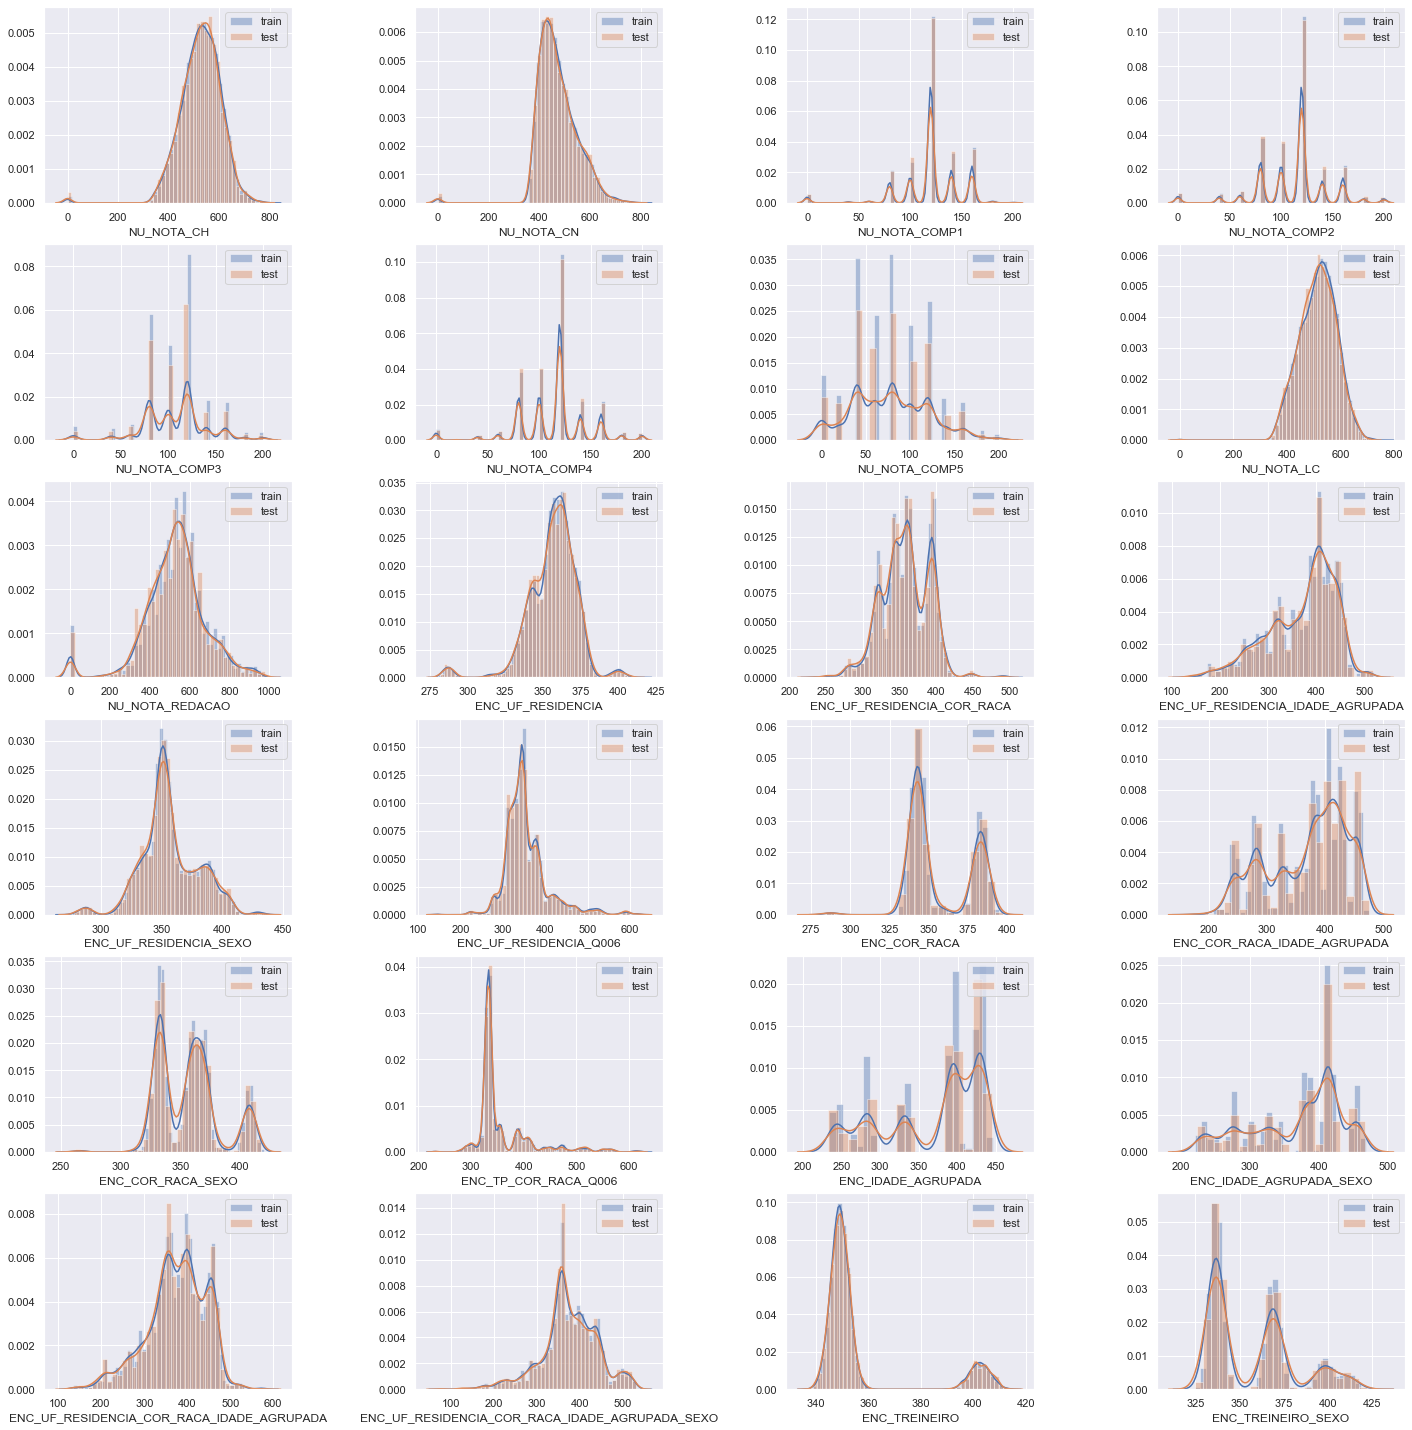

In [75]:
gen_distplots(train_data, test_data, features=numeric_features, cols=4)

Podemos observar que as bases de treino e teste estão muito próximas em termos de distribuição.

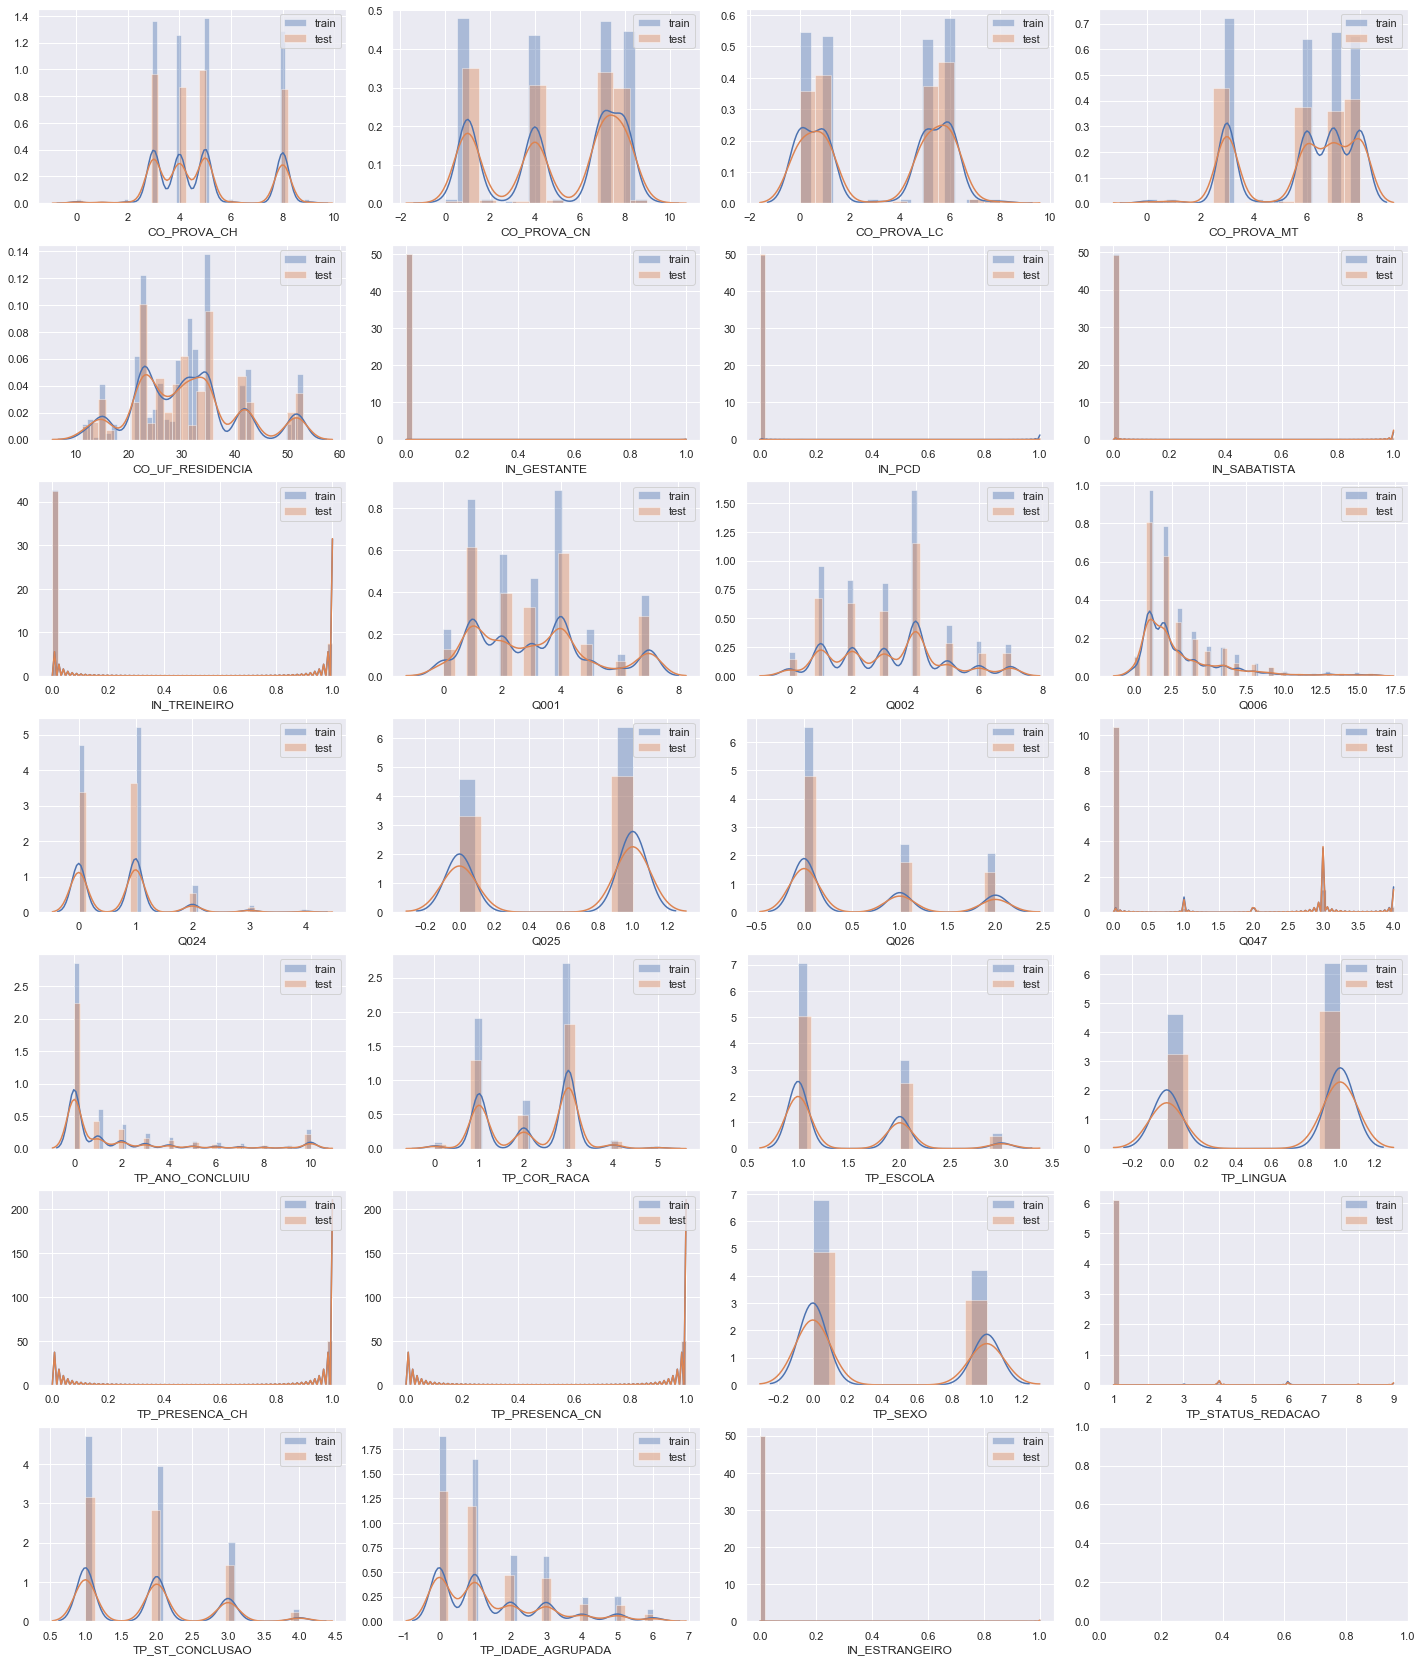

In [76]:
gen_distplots(train_data, test_data, features=categorical_features, cols=4)

## Preparando `X` e `y` de treino e teste

In [77]:
train_data, test_data = data.xs('train'), data.xs('test')

In [78]:
mask_train = (train_data['ELIMINADO']==0)
mask_test = (test_data['ELIMINADO']==0)

In [79]:
X = train_data[mask_train].drop(columns=['NU_INSCRICAO', 'ELIMINADO', target_col])
y = train_data.loc[mask_train, target_col]

X_test = test_data[mask_test].drop(columns=['NU_INSCRICAO', 'ELIMINADO', target_col])

## Procurando por outliers

Vamos verificar agora se nossa base possui ou não outliers ou anomalias.

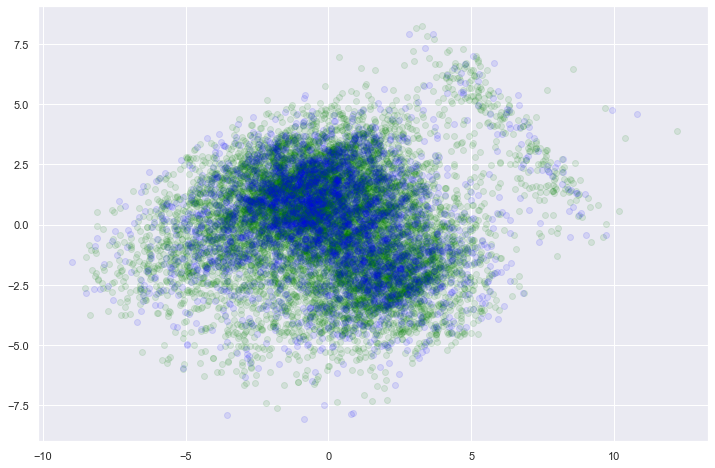

In [80]:
scaler = StandardScaler().fit(X[numeric_features])
X_train_scaled = scaler.transform(X[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

pca = PCA(n_components=2).fit(X_train_scaled)

train_points = pca.transform(X_train_scaled)
plt.scatter(train_points[:, 0], train_points[:, 1], c='green', alpha=0.1)

test_points = pca.transform(X_test_scaled)
plt.scatter(test_points[:, 0], test_points[:, 1], c='blue', alpha=0.1);

Com `PCA` podemos ter uma visualização mais fácil dos nossos dados. Vamos agora usar o `LocalOutlierFactor` para visualizar o que ele detecta como outlier.

In [83]:
outlier_detector = LocalOutlierFactor(n_neighbors=20, contamination=0.003, novelty=True).fit(X_train_scaled)
mask = outlier_detector.predict(X_train_scaled)==-1

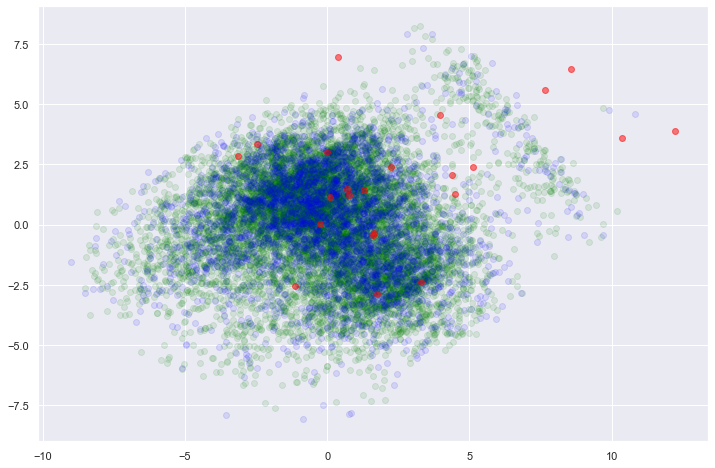

In [84]:
pca = PCA(n_components=2).fit(X_train_scaled)

train_points = pca.transform(X_train_scaled[~mask])
plt.scatter(train_points[:, 0], train_points[:, 1], c='green', alpha=0.1)

test_points = pca.transform(X_test_scaled)
plt.scatter(test_points[:, 0], test_points[:, 1], c='blue', alpha=0.1)

outliers = pca.transform(X_train_scaled[mask])
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', alpha=0.5);

Se compararmos com a projeção original, veremos que parte do que detectamos fica realmente isolado.

In [86]:
mask = outlier_detector.predict(X_train_scaled)!=-1
X, y = X[mask], y[mask]

## Criando nosso modelo

Vamos criar duas abordagem, uma bem simples com regressão linear e outra mais complexa com o LightGBM.

Criando bases de treino e validação.

In [87]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

### 1ª tentativa: Uma regressão linear simples

Vamos criar um pipeline onde imputaremos zero para valores nulos além da padronização para as features numéricas e para as features categóricas, vamos usar `OneHotEncoder`.

In [88]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ], 
    remainder='drop'
)

preprocessor.fit(X)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_COMP1',
                                  'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
                                  'NU_NOTA_COMP4', 'NU_NOTA_COMP5',
                                  'NU_NOTA_LC', 'NU_NOTA_REDACAO',
                                  'ENC_UF_RESIDENCIA',
                                  'ENC_UF_RESIDENCIA_COR_RACA',
                                  'ENC_UF_RESIDENCIA_IDADE_AGRUPADA',
                                  'ENC_UF_RESIDENCIA_SEXO',
                                  'ENC_UF_RESIDENCIA...
                                 ['CO_PROVA_CH', 'CO_PROVA_CN', 'CO_PROVA_LC',
                                  'CO_PROVA_MT', 'CO_UF_RESIDENCIA',
                                  'IN_GESTANTE', 'IN_PCD', 'IN_SABATISTA',
                                  'IN_TREINEIRO', 'Q001', 'Q002', 'Q006',
                                  'Q024', 'Q025', 'Q026', 'Q047',
                                  'TP_ANO_CONCLUIU', 'TP_COR_RACA', 'TP_ESCOLA',
                                  'TP_LINGUA', 'TP_PRESENCA_CH',
                                  'TP_PRESENCA_CN', 'TP_SEXO',
                                  'TP_STATUS_REDACAO', 'TP_ST_CONCLUSAO',
                                  'TP_IDADE_AGRUPADA', 'IN_ESTRANGEIRO'])])

Transformamos todos os nossos dados.

In [89]:
X_train_transf = preprocessor.transform(X_train)
X_valid_transf = preprocessor.transform(X_valid)
X_test_transf = preprocessor.transform(X_test)

Criamos nosso modelo.

In [90]:
linear_model = LinearRegression().fit(X_train_transf, y_train)

Vamos validar os erros com RMSE, MAE e R2.

In [91]:
def root_mean_squared_error(y_true, y_pred):
    """
    Calcula RMSE.
    
    :param y_true: targets reais
    :param y_pred: targets preditos
    :returns: RMSE
    """
    return mean_squared_error(y_true, y_pred, squared=False)

In [92]:
preds = linear_model.predict(X_valid_transf)
print('RMSE:', root_mean_squared_error(y_valid, preds))
print('MAE:', mean_absolute_error(y_valid, preds))
print('R2:', r2_score(y_valid, preds))

RMSE: 74.89434894795788
MAE: 58.53650034017813
R2: 0.45699227185186275


Nesse caso aqui, meu score ficou em torno de 93.61%.

### 2ª tentativa: Usando LightGBM

O resultado não foi ruim para uma regressão linear. Poderíamos explorar outras estratégias, mas eu particularmente prefiro explorar com LightGBM.

In [97]:
def kfold_lightgbm(X_train, y_train, X_test, categorical_features, lgb_params, num_folds, random_state):
    """
    Monta modelo LightGBM com KFold. Num futuro podemos englobar isso em um modelo no padrão scikit-learn.
    
    :param X_train: dados de treino
    :param y_train: target de treino
    :param X_test: dados de teste
    :param categorical_features: lista com as features categóricas
    :param lgb_params: parâmetros para o modelo
    :param num_folds: número de partições
    :param random_state: semente randômica
    :returns: target previsto para a base de teste
    """
    folds = KFold(n_splits=num_folds, shuffle=True, random_state=random_state)
    # criando arrays para armazenarmos os resultados
    oof_preds = np.zeros(X_train.shape[0])
    sub_preds = np.zeros(X_test.shape[0])
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
        train_x, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_x, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        # configurando nossos parâmetros
        reg = lgb.LGBMRegressor(n_estimators=1000, random_state=random_state)
        reg.set_params(**lgb_params)
        
        reg.fit(
            train_x, 
            train_y, 
            categorical_feature=categorical_features,
            eval_metric='mae', 
            eval_set=[(valid_x, valid_y)],
            verbose=False, 
            early_stopping_rounds=30)

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration_)
        sub_preds += reg.predict(X_test, num_iteration=reg.best_iteration_) / folds.n_splits
        
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()
    
    return sub_preds

Como temos muitos parâmetros para testar. Vamos tunar nossos hiperparâmetros com `optuna`.

In [98]:
LGB_FIXED_PARAMS = {
    'random_state': 0,
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
}

def lgb_objective(trial):
    params = {
        **LGB_FIXED_PARAMS,
        'max_depth': trial.suggest_categorical('max_depth', [-1] + list(range(4, 15))),
        'num_leaves': trial.suggest_categorical('num_leaves', [2**i for i in range(4, 15)]),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.),
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.),
        'min_child_weight': trial.suggest_int('min_child_weight', 50, 500),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 5.),
    }
    
    preds = kfold_lightgbm(X_train, y_train, X_valid, categorical_features, lgb_params=params, num_folds=5, random_state=0)
    score = mean_absolute_error(y_valid, preds)
    return score

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=0))

In [99]:
study.optimize(lgb_objective, n_trials=200)

[I 2020-05-28 14:44:39,420] Finished trial#0 with value: 57.21980591517247 with parameters: {'max_depth': 8, 'num_leaves': 16, 'colsample_bytree': 0.8808290128214932, 'subsample': 0.863464954899069, 'min_child_weight': 59, 'lambda_l2': 0.0026568185455579404}. Best is trial#0 with value: 57.21980591517247.
[I 2020-05-28 14:44:44,714] Finished trial#1 with value: 57.982070569686215 with parameters: {'max_depth': 5, 'num_leaves': 256, 'colsample_bytree': 0.7892603819633417, 'subsample': 0.7170138931952329, 'min_child_weight': 446, 'lambda_l2': 2.165440577786049e-05}. Best is trial#0 with value: 57.21980591517247.
[I 2020-05-28 14:44:51,242] Finished trial#2 with value: 57.78555106999777 with parameters: {'max_depth': 9, 'num_leaves': 2048, 'colsample_bytree': 0.8586684759258714, 'subsample': 0.8704133683281796, 'min_child_weight': 215, 'lambda_l2': 0.18750984951329078}. Best is trial#0 with value: 57.21980591517247.
[I 2020-05-28 14:44:59,048] Finished trial#3 with value: 57.8839866539652

[I 2020-05-28 14:47:34,964] Finished trial#26 with value: 57.24357298951241 with parameters: {'max_depth': 4, 'num_leaves': 512, 'colsample_bytree': 0.9821872471248695, 'subsample': 0.758964775698839, 'min_child_weight': 103, 'lambda_l2': 0.21462925145095088}. Best is trial#24 with value: 57.182209773803166.
[I 2020-05-28 14:47:41,334] Finished trial#27 with value: 57.282635648616605 with parameters: {'max_depth': 4, 'num_leaves': 512, 'colsample_bytree': 0.9685988982032239, 'subsample': 0.7428647714969269, 'min_child_weight': 90, 'lambda_l2': 0.008998273207819039}. Best is trial#24 with value: 57.182209773803166.
[I 2020-05-28 14:47:48,595] Finished trial#28 with value: 57.16088344863678 with parameters: {'max_depth': 4, 'num_leaves': 512, 'colsample_bytree': 0.9099192327148604, 'subsample': 0.7893426950470238, 'min_child_weight': 52, 'lambda_l2': 0.058883492386508814}. Best is trial#28 with value: 57.16088344863678.
[I 2020-05-28 14:47:54,733] Finished trial#29 with value: 57.0863756

[I 2020-05-28 14:50:31,361] Finished trial#52 with value: 57.20519548474331 with parameters: {'max_depth': 4, 'num_leaves': 128, 'colsample_bytree': 0.9514560027589245, 'subsample': 0.8565065293137896, 'min_child_weight': 65, 'lambda_l2': 4.894404032485311}. Best is trial#29 with value: 57.086375653604094.
[I 2020-05-28 14:50:36,418] Finished trial#53 with value: 57.227904623005664 with parameters: {'max_depth': 4, 'num_leaves': 128, 'colsample_bytree': 0.889252347657521, 'subsample': 0.875471955380056, 'min_child_weight': 88, 'lambda_l2': 0.86563947645961}. Best is trial#29 with value: 57.086375653604094.
[I 2020-05-28 14:50:44,316] Finished trial#54 with value: 57.77450065089138 with parameters: {'max_depth': 11, 'num_leaves': 128, 'colsample_bytree': 0.9282024081380836, 'subsample': 0.7825152950994162, 'min_child_weight': 104, 'lambda_l2': 2.2340588401161563}. Best is trial#29 with value: 57.086375653604094.
[I 2020-05-28 14:50:49,350] Finished trial#55 with value: 57.17408581153537

[I 2020-05-28 14:53:42,767] Finished trial#78 with value: 57.335001099942225 with parameters: {'max_depth': 5, 'num_leaves': 16, 'colsample_bytree': 0.8725361075746468, 'subsample': 0.8707032555867467, 'min_child_weight': 91, 'lambda_l2': 4.943057211291032}. Best is trial#29 with value: 57.086375653604094.
[I 2020-05-28 14:53:48,152] Finished trial#79 with value: 57.292584641115596 with parameters: {'max_depth': 5, 'num_leaves': 16, 'colsample_bytree': 0.9018211441046265, 'subsample': 0.8788660656135047, 'min_child_weight': 50, 'lambda_l2': 0.5482690640339904}. Best is trial#29 with value: 57.086375653604094.
[I 2020-05-28 14:53:55,041] Finished trial#80 with value: 57.66728970462673 with parameters: {'max_depth': 9, 'num_leaves': 64, 'colsample_bytree': 0.8650658303316016, 'subsample': 0.848801225264056, 'min_child_weight': 86, 'lambda_l2': 1.1752806170049086}. Best is trial#29 with value: 57.086375653604094.
[I 2020-05-28 14:54:04,859] Finished trial#81 with value: 57.68373774106328 

[I 2020-05-28 14:56:24,293] Finished trial#104 with value: 57.25201517921491 with parameters: {'max_depth': 4, 'num_leaves': 512, 'colsample_bytree': 0.9457137203438876, 'subsample': 0.7848723560617332, 'min_child_weight': 90, 'lambda_l2': 0.17800073478487696}. Best is trial#29 with value: 57.086375653604094.
[I 2020-05-28 14:56:29,300] Finished trial#105 with value: 57.174535244783705 with parameters: {'max_depth': 4, 'num_leaves': 16384, 'colsample_bytree': 0.8878213082954569, 'subsample': 0.8466251943278726, 'min_child_weight': 60, 'lambda_l2': 0.9388184445384492}. Best is trial#29 with value: 57.086375653604094.
[I 2020-05-28 14:56:34,639] Finished trial#106 with value: 57.27471747415932 with parameters: {'max_depth': 4, 'num_leaves': 2048, 'colsample_bytree': 0.9291688457979747, 'subsample': 0.8049776299563897, 'min_child_weight': 78, 'lambda_l2': 0.031961654536269694}. Best is trial#29 with value: 57.086375653604094.
[I 2020-05-28 14:56:39,599] Finished trial#107 with value: 57.4

[I 2020-05-28 14:58:55,814] Finished trial#130 with value: 57.227627154971486 with parameters: {'max_depth': 4, 'num_leaves': 1024, 'colsample_bytree': 0.909802692473228, 'subsample': 0.8680871454225023, 'min_child_weight': 88, 'lambda_l2': 9.445905140997571e-06}. Best is trial#29 with value: 57.086375653604094.
[I 2020-05-28 14:59:00,523] Finished trial#131 with value: 57.22063842760072 with parameters: {'max_depth': 4, 'num_leaves': 512, 'colsample_bytree': 0.9228274963758217, 'subsample': 0.8388987996023718, 'min_child_weight': 76, 'lambda_l2': 0.0002453145737010454}. Best is trial#29 with value: 57.086375653604094.
[I 2020-05-28 14:59:05,217] Finished trial#132 with value: 57.23267218213175 with parameters: {'max_depth': 4, 'num_leaves': 512, 'colsample_bytree': 0.9181230818866273, 'subsample': 0.8551811387928382, 'min_child_weight': 69, 'lambda_l2': 0.006617293329008345}. Best is trial#29 with value: 57.086375653604094.
[I 2020-05-28 14:59:09,817] Finished trial#133 with value: 57

[I 2020-05-28 15:01:25,788] Finished trial#156 with value: 57.18467938000782 with parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.8122126870706756, 'subsample': 0.7050511255705513, 'min_child_weight': 57, 'lambda_l2': 1.7221192210550211}. Best is trial#151 with value: 57.06452572967336.
[I 2020-05-28 15:01:30,867] Finished trial#157 with value: 57.14672863738264 with parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.8152478202969476, 'subsample': 0.7261601811973429, 'min_child_weight': 74, 'lambda_l2': 1.1611495421774953}. Best is trial#151 with value: 57.06452572967336.
[I 2020-05-28 15:01:36,426] Finished trial#158 with value: 57.287843537952156 with parameters: {'max_depth': 9, 'num_leaves': 16, 'colsample_bytree': 0.7761407784664863, 'subsample': 0.723870006561606, 'min_child_weight': 88, 'lambda_l2': 1.1649138266730068}. Best is trial#151 with value: 57.06452572967336.
[I 2020-05-28 15:01:41,170] Finished trial#159 with value: 57.16493191727

[I 2020-05-28 15:03:36,496] Finished trial#182 with value: 57.15460528556272 with parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.8185618255594695, 'subsample': 0.7004531005838844, 'min_child_weight': 90, 'lambda_l2': 0.6377480314825964}. Best is trial#172 with value: 57.033035431113554.
[I 2020-05-28 15:03:41,786] Finished trial#183 with value: 57.113761262509676 with parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.8328914775697736, 'subsample': 0.7000363218112015, 'min_child_weight': 74, 'lambda_l2': 0.27696321529779255}. Best is trial#172 with value: 57.033035431113554.
[I 2020-05-28 15:03:46,764] Finished trial#184 with value: 57.01195795364623 with parameters: {'max_depth': 4, 'num_leaves': 16, 'colsample_bytree': 0.8389417517205009, 'subsample': 0.7069429362578096, 'min_child_weight': 70, 'lambda_l2': 0.26072442710894383}. Best is trial#184 with value: 57.01195795364623.
[I 2020-05-28 15:03:51,882] Finished trial#185 with value: 57.120181

In [100]:
study.best_params

{'max_depth': 4,
 'num_leaves': 16,
 'colsample_bytree': 0.8389417517205009,
 'subsample': 0.7069429362578096,
 'min_child_weight': 70,
 'lambda_l2': 0.26072442710894383}

Beleza! Chegamos nos nossos melhores hiperparâmetros.

In [101]:
optuna.visualization.plot_optimization_history(study)

In [103]:
lgb_best_params = {**study.best_params, **LGB_FIXED_PARAMS}
preds = kfold_lightgbm(X_train, y_train, X_valid, categorical_features, lgb_best_params, num_folds=5, random_state=0)

In [104]:
print('RMSE:', root_mean_squared_error(y_valid, preds))
print('MAE:', mean_absolute_error(y_valid, preds))
print('R2:', r2_score(y_valid, preds))

RMSE: 72.85145373036254
MAE: 57.01195795364623
R2: 0.48621152792083


## Exportando os dados

In [105]:
preds = kfold_lightgbm(X_train, y_train, X_test, categorical_features, lgb_best_params, num_folds=5, random_state=0)
output_data = df_test.iloc[:, [0]]
output_data.loc[mask_test, target_col] = np.clip(preds, 0., 1000.)
output_data.loc[~mask_test, target_col] = 0
print(output_data)

                                  NU_INSCRICAO  NU_NOTA_MT
0     73ff9fcc02f0a99919906c942c2e1a1042cdcf98  439.302289
1     71a95f9f1b91a82c65ad94abbdf9f54e6066f968  438.518612
2     b38a03232f43b11c9d0788abaf060f7366053b6d  607.176817
3     70b682d9a3636be23f6120fa9d6b164eb3c6002d    0.000000
4     715494628a50142ce8cb17191cfe6d0f3cae0934  576.396878
5     e656d6bad65c93fb2880f1eba5037008c8e75774  475.295690
6     465cd2a6907fb37d9d8ad3c065f0e2dabdba9b13  520.874065
7     11539e86171bf07d3a36f09377d7f54ebcc8406a  427.521770
8     043c544a2104aa8a9849f1a703a08d37a2f16839  465.589806
9     76ba050e64ad100b856f0eaabd8f539d5c7dd185  451.065977
10    8b7c167ea7b55c8168ec60c3851b1b598a8fbd11    0.000000
11    db4da599aab5bb08dce27094a35fd3e36cd0abce    0.000000
12    940aede382ccb332fab15d413217695ec44ca765  464.336502
13    9ad714b116da76d878dd399d187fccc2dd13dd63  587.265911
14    dd34464a4d780b12a089347ad580418ac57a3055  509.589314
15    f837a4cb05a5fd59d20138182f5e8c721eadd584  478.7031

In [106]:
output_data.to_csv('answer.csv', index=False)